In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df_real_estate = pd.read_csv('Real_Estate_Sales_2001-2022_GL.csv')
df_real_estate.head()

C:\Users\anima\AppData\Local\Temp\ipykernel_21596\3007741456.py:6: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_real_estate = pd.read_csv('Real_Estate_Sales_2001-2022_GL.csv')


,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.5354,Residential,Single Family,NaN,NaN,NaN,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,0.4606,Residential,Three Family,NaN,NaN,NaN,NaN
2,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN,NaN,NaN
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.6291,Residential,Two Family,NaN,NaN,NaN,NaN
4,210288,2021,06/20/2022,Avon,12 BYRON DRIVE,179990.0,362500.0,0.4965,Residential,Condo,NaN,NaN,NaN,POINT (-72.879115982 41.773452988)


Here is a list of columns I'm going to remove for this demonstration.
| Row to Remove    | Data Type | Reason for Removal                                 |
|------------------|-----------|----------------------------------------------------|
| Serial Number    | int64     | Identifier field. No data for learning here.       |
| List Year        | int64     | Repeated in `Date Recorded` field.                 |
| Address          | object    | Captured in `Location` field.                      |
| Sales Ratio      | float64   | Data leakage.                                      |
| Non Use Code     | object    | I'm lazy.                                          |
| Assessor Remarks | object    | Textual data not used for this regression problem. |
| OPM Remarks      | object    | See above.                                         |

In [2]:
# Parsing the Location column
df_real_estate['Location'] = df_real_estate['Location'].replace("NaN", pd.NA)
df_real_estate['Longitude'] = df_real_estate['Location'].str.extract(r"POINT \((-?\d+\.\d+)")
df_real_estate['Latitude'] = df_real_estate['Location'].str.extract(r" (-?\d+\.\d+)\)")

# Force the columns we just created to become numeric
df_real_estate["Longitude"] = pd.to_numeric(df_real_estate["Longitude"], errors="coerce")
df_real_estate["Latitude"] = pd.to_numeric(df_real_estate["Latitude"], errors="coerce")


In [3]:
columns_to_drop = ['Serial Number', 'List Year',
                   'Address', 'Sales Ratio', 'Non Use Code',
                   'Assessor Remarks', 'OPM remarks', 'Location']

df_re_dropped = df_real_estate.drop(columns = columns_to_drop)

df_re_dropped.head()

,Date Recorded,Town,Assessed Value,Sale Amount,Property Type,Residential Type,Longitude,Latitude
0,04/14/2021,Ansonia,133000.0,248400.0,Residential,Single Family,-73.068220,41.350140
1,05/26/2021,Ansonia,110500.0,239900.0,Residential,Three Family,NaN,NaN
2,09/13/2021,Ansonia,150500.0,325000.0,Commercial,NaN,NaN,NaN
3,12/14/2020,Ansonia,127400.0,202500.0,Residential,Two Family,NaN,NaN
4,06/20/2022,Avon,179990.0,362500.0,Residential,Condo,-72.879116,41.773453


There are still some Latitudes and Longitudes missing, so we will impute them based on the Town, and just get the means per each group. 
*(Extra exercise here is to determine how good or bad of a move this is!)*

In [4]:
town_means = df_re_dropped.groupby("Town")[["Longitude", "Latitude"]].mean()
df_re_dropped["Longitude"] = df_re_dropped.apply(
    lambda row: town_means.loc[row["Town"], "Longitude"] if pd.isna(row["Longitude"]) else row["Longitude"],
    axis=1
)
df_re_dropped["Latitude"] = df_re_dropped.apply(
    lambda row: town_means.loc[row["Town"], "Latitude"] if pd.isna(row["Latitude"]) else row["Longitude"],
    axis=1
)
df_re_dropped.head()

,Date Recorded,Town,Assessed Value,Sale Amount,Property Type,Residential Type,Longitude,Latitude
0,04/14/2021,Ansonia,133000.0,248400.0,Residential,Single Family,-73.068220,-73.068220
1,05/26/2021,Ansonia,110500.0,239900.0,Residential,Three Family,-73.074201,41.342789
2,09/13/2021,Ansonia,150500.0,325000.0,Commercial,NaN,-73.074201,41.342789
3,12/14/2020,Ansonia,127400.0,202500.0,Residential,Two Family,-73.074201,41.342789
4,06/20/2022,Avon,179990.0,362500.0,Residential,Condo,-72.879116,-72.879116


Of course, with this adjustment, I've just introduced more colinearity, so we can safely drop `Town` from our dataset.

Also, there are some data that seem to be **missing completely at random** so I will impute them with the mode.

Last thing I will need to do as far as transformations go is to change the date to a datetime object. Then parse that into their Year/Month/Days.

In [5]:
df_re_almost = df_re_dropped.drop(columns = ["Town"])
df_filled = df_re_almost.apply(lambda col: col.fillna(col.mode()[0]) if not col.mode().empty else col)
df_filled["Date Recorded"] = pd.to_datetime(df_filled["Date Recorded"], format="%m/%d/%Y")
df_filled["Year"] = df_filled["Date Recorded"].dt.year
df_filled["Month"] = df_filled["Date Recorded"].dt.month
df_filled["Day"] = df_filled["Date Recorded"].dt.day
df_filled = df_filled.drop(columns = ["Date Recorded"])
df_filled.head()

,Assessed Value,Sale Amount,Property Type,Residential Type,Longitude,Latitude,Year,Month,Day
0,133000.0,248400.0,Residential,Single Family,-73.068220,-73.068220,2021,4,14
1,110500.0,239900.0,Residential,Three Family,-73.074201,41.342789,2021,5,26
2,150500.0,325000.0,Commercial,Single Family,-73.074201,41.342789,2021,9,13
3,127400.0,202500.0,Residential,Two Family,-73.074201,41.342789,2020,12,14
4,179990.0,362500.0,Residential,Condo,-72.879116,-72.879116,2022,6,20


Time to fit some models. It's always good to have a base linear regression model to compare to. In order to prep this data for linear regression, we first need to transform it to be numerical, meaning taking our categorical variables and blowing them up with **one-hot** encoding. The shape of our data will then transform into 1million x 23, but should be fine in the end.

In [6]:
df_encoded = pd.get_dummies(df_filled, columns=["Property Type", "Residential Type"])
df_encoded.head()

,Assessed Value,Sale Amount,Longitude,Latitude,Year,Month,Day,Property Type_Apartments,Property Type_Commercial,Property Type_Condo,...,Property Type_Residential,Property Type_Single Family,Property Type_Three Family,Property Type_Two Family,Property Type_Vacant Land,Residential Type_Condo,Residential Type_Four Family,Residential Type_Single Family,Residential Type_Three Family,Residential Type_Two Family
0,133000.0,248400.0,-73.068220,-73.068220,2021,4,14,False,False,False,...,True,False,False,False,False,False,False,True,False,False
1,110500.0,239900.0,-73.074201,41.342789,2021,5,26,False,False,False,...,True,False,False,False,False,False,False,False,True,False
2,150500.0,325000.0,-73.074201,41.342789,2021,9,13,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,127400.0,202500.0,-73.074201,41.342789,2020,12,14,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,179990.0,362500.0,-72.879116,-72.879116,2022,6,20,False,False,False,...,True,False,False,False,False,True,False,False,False,False


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df_encoded.drop(columns=["Sale Amount"])
y = df_encoded["Sale Amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.2)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae: .2f}")
print(f"Mean Squared Error: {mse: .2f}")
print(f"R2 Score: {r2: .2f}")

Mean Absolute Error:  284968.37
Mean Squared Error:  117987300058475.55
R2 Score:  0.01


Wow. This model is pretty bad. Let's go ahead and visualize how bad it looks!

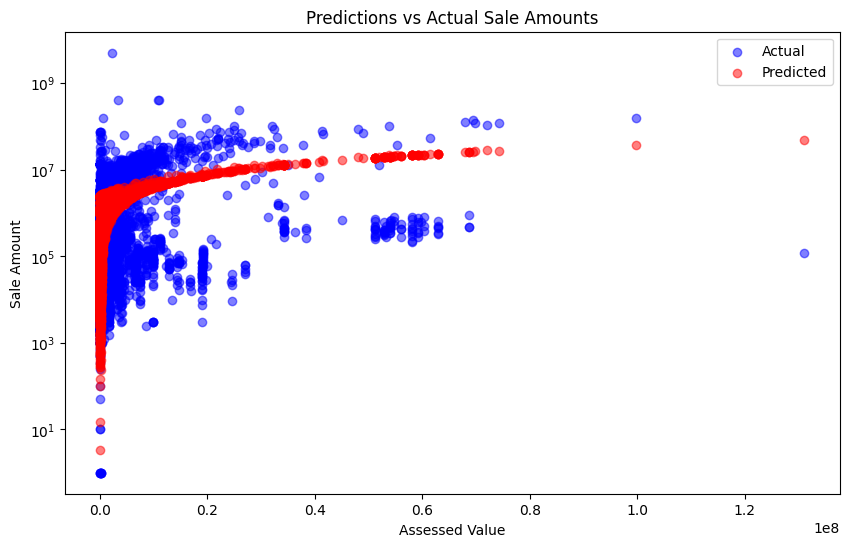

In [8]:
sorted_indices = np.argsort(y_test)

X_test_sorted = X_test.iloc[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

plt.figure(figsize=(10, 6))
plt.scatter(X_test_sorted["Assessed Value"], y_test_sorted, label="Actual", color="blue", alpha = .5)
plt.scatter(X_test_sorted["Assessed Value"], y_pred_sorted, label="Predicted", color="red", alpha = .5)

plt.xlabel("Assessed Value")
plt.ylabel("Sale Amount")
plt.title("Predictions vs Actual Sale Amounts")
plt.yscale("log")
plt.legend()
plt.show()

Now let's look at throwing a more robust model at this data. Before running the following cell, it's pertinent to look at the grid search and think about how many models are actually being fit/trained/evaluated.

In [ ]:
# If you're following through this notebook, do not actually run this code.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

df = df_encoded.copy()

X = df.drop(columns=["Sale Amount"])
y = df["Sale Amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
# Dictionary for our different models to set up for GridSearchCV
models = {
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(n_jobs=-1),
    "Polynomial": make_pipeline(PolynomialFeatures(), LinearRegression())
}

param_grids = {
    "DecisionTree": {
        "max_depth": [5, 10, 15, 20],
        "min_samples_split": [x for x in range(2, 10)],
        "max_features": [x for x in range(1, len(X.columns) - 1)] # 22 max features
    },
    "RandomForest": {
        "n_estimators": [x for x in range(5, 100, 5)],
        "max_depth": [x for x in range(5, 20)],
        "min_samples_split": [x for x in range(2, 20)],
        "max_features": [x for x in range(1, len(X.columns) - 1)]
    },
    "Polynomial": {
        "polynomialfeatures__degree": [x for x in range(1, 5)]
    }
}

# Perform the grid search for the best models/hyperparameters
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, # model to use
                               param_grids[name], # hyperparameters to search through
                               cv=5, # number of cross validations to score through
                               scoring="neg_mean_squared_error", #scoring method
                               n_jobs=-1) # use all cores on the cpu
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

# Final evaluation on the test set
test_results = {}
for name, model in best_models.items():
    y_test_pred = model.predict(X_test)
    test_results[name] = {
        "MAE": mean_absolute_error(y_test, y_test_pred),
        "MSE": mean_squared_error(y_test, y_test_pred),
        "R2": r2_score(y_test, y_test_pred)
    }

    # Plotting the predictions against the actual values
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test, y_test_pred, alpha=.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label = "Ideal Prediction"))
    plt.xlabel("Actual Sale Amount")
    plt.ylabel("Predicted Sale Amount")
    plt.title(f"Actual vs Predicted Sale Amounts ({name} model)")
    plt.show()

PicklingError: Could not pickle the task to send it to the workers.

: 

Shoot. Just to show what happened above:
```
---------------------------------------------------------------------------
_RemoteTraceback                          Traceback (most recent call last)
_RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\externals\loky\backend\queues.py", line 159, in _feed
    obj_ = dumps(obj, reducers=reducers)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\externals\loky\backend\reduction.py", line 215, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\externals\loky\backend\reduction.py", line 208, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\externals\cloudpickle\cloudpickle.py", line 1245, in dump
    return super().dump(obj)
           ^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\_memmapping_reducer.py", line 451, in __call__
    for dumped_filename in dump(a, filename):
                           ^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\numpy_pickle.py", line 553, in dump
    NumpyPickler(f, protocol=protocol).dump(value)
  File "c:\ProgramData\anaconda3\envs\mlops\Lib\pickle.py", line 484, in dump
    self.save(obj)
  File "c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\numpy_pickle.py", line 352, in save
    wrapper.write_array(obj, self)
  File "c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\numpy_pickle.py", line 134, in write_array
    pickler.file_handle.write(chunk.tobytes('C'))
OSError: [Errno 28] No space left on device
"""

The above exception was the direct cause of the following exception:

PicklingError                             Traceback (most recent call last)
Cell In[9], line 46
     40 for name, model in models.items():
     41     grid_search = GridSearchCV(model, # model to use
     42                                param_grids[name], # hyperparameters to search through
     43                                cv=5, # number of cross validations to score through
     44                                scoring="neg_mean_squared_error", #scoring method
     45                                n_jobs=-1) # use all cores on the cpu
---> 46     grid_search.fit(X_train, y_train)
     47     best_models[name] = grid_search.best_estimator_

File c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\base.py:1473, in _fit_context.<locals>.decorator.<locals>.wrapper(estimator, *args, **kwargs)
   1466     estimator._validate_params()
   1468 with config_context(
   1469     skip_parameter_validation=(
   1470         prefer_skip_nested_validation or global_skip_validation
   1471     )
   1472 ):
-> 1473     return fit_method(estimator, *args, **kwargs)

File c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\model_selection\_search.py:1018, in BaseSearchCV.fit(self, X, y, **params)
   1012     results = self._format_results(
   1013         all_candidate_params, n_splits, all_out, all_more_results
   1014     )
   1016     return results
-> 1018 self._run_search(evaluate_candidates)
   1020 # multimetric is determined here because in the case of a callable
   1021 # self.scoring the return type is only known after calling
   1022 first_test_score = all_out[0]["test_scores"]

File c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\model_selection\_search.py:1572, in GridSearchCV._run_search(self, evaluate_candidates)
   1570 def _run_search(self, evaluate_candidates):
   1571     """Search all candidates in param_grid"""
-> 1572     evaluate_candidates(ParameterGrid(self.param_grid))

File c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\model_selection\_search.py:964, in BaseSearchCV.fit.<locals>.evaluate_candidates(candidate_params, cv, more_results)
    956 if self.verbose > 0:
    957     print(
    958         "Fitting {0} folds for each of {1} candidates,"
    959         " totalling {2} fits".format(
    960             n_splits, n_candidates, n_candidates * n_splits
    961         )
    962     )
--> 964 out = parallel(
    965     delayed(_fit_and_score)(
    966         clone(base_estimator),
    967         X,
    968         y,
    969         train=train,
    970         test=test,
    971         parameters=parameters,
    972         split_progress=(split_idx, n_splits),
    973         candidate_progress=(cand_idx, n_candidates),
    974         **fit_and_score_kwargs,
    975     )
    976     for (cand_idx, parameters), (split_idx, (train, test)) in product(
    977         enumerate(candidate_params),
    978         enumerate(cv.split(X, y, **routed_params.splitter.split)),
    979     )
    980 )
    982 if len(out) < 1:
    983     raise ValueError(
    984         "No fits were performed. "
    985         "Was the CV iterator empty? "
    986         "Were there no candidates?"
    987     )

File c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\utils\parallel.py:74, in Parallel.__call__(self, iterable)
     69 config = get_config()
     70 iterable_with_config = (
     71     (_with_config(delayed_func, config), args, kwargs)
     72     for delayed_func, args, kwargs in iterable
     73 )
---> 74 return super().__call__(iterable_with_config)

File c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\parallel.py:2007, in Parallel.__call__(self, iterable)
   2001 # The first item from the output is blank, but it makes the interpreter
   2002 # progress until it enters the Try/Except block of the generator and
   2003 # reaches the first `yield` statement. This starts the asynchronous
   2004 # dispatch of the tasks to the workers.
   2005 next(output)
-> 2007 return output if self.return_generator else list(output)

File c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\parallel.py:1650, in Parallel._get_outputs(self, iterator, pre_dispatch)
   1647     yield
   1649     with self._backend.retrieval_context():
-> 1650         yield from self._retrieve()
   1652 except GeneratorExit:
   1653     # The generator has been garbage collected before being fully
   1654     # consumed. This aborts the remaining tasks if possible and warn
   1655     # the user if necessary.
   1656     self._exception = True

File c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\parallel.py:1754, in Parallel._retrieve(self)
   1747 while self._wait_retrieval():
   1748 
   1749     # If the callback thread of a worker has signaled that its task
   1750     # triggered an exception, or if the retrieval loop has raised an
   1751     # exception (e.g. `GeneratorExit`), exit the loop and surface the
   1752     # worker traceback.
   1753     if self._aborting:
-> 1754         self._raise_error_fast()
   1755         break
   1757     # If the next job is not ready for retrieval yet, we just wait for
   1758     # async callbacks to progress.

File c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\parallel.py:1789, in Parallel._raise_error_fast(self)
   1785 # If this error job exists, immediately raise the error by
   1786 # calling get_result. This job might not exists if abort has been
   1787 # called directly or if the generator is gc'ed.
   1788 if error_job is not None:
-> 1789     error_job.get_result(self.timeout)

File c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\parallel.py:745, in BatchCompletionCallBack.get_result(self, timeout)
    739 backend = self.parallel._backend
    741 if backend.supports_retrieve_callback:
    742     # We assume that the result has already been retrieved by the
    743     # callback thread, and is stored internally. It's just waiting to
    744     # be returned.
--> 745     return self._return_or_raise()
    747 # For other backends, the main thread needs to run the retrieval step.
    748 try:

File c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\joblib\parallel.py:763, in BatchCompletionCallBack._return_or_raise(self)
    761 try:
    762     if self.status == TASK_ERROR:
--> 763         raise self._result
    764     return self._result
    765 finally:

PicklingError: Could not pickle the task to send it to the workers.
```

Basically, it looks like the for loop ran for too long and eventually the data couldn't be pickled/allocated correctly.

# Installation and Use of MLflow

In your terminal (after activating a desired environment) run `pip install mlflow`. This will install the latest version of MLflow for the given environment. Let's use it for this notebook now. Follow along below, we're still using `df` as assigned from above. However, for the simplicity of this demonstration, we'll look at a subset of what we grid searched.

In a terminal, make sure you run the following code so you can see the output later:
`mlflow server --host 127.0.0.1 --port 8080`

In [9]:
# Creating a function for logging in mlflow
def plot_predictions_vs_actual(X_test, y_test, y_pred):
    sorted_indices = np.argsort(y_test)
    X_test_sorted = X_test.iloc[sorted_indices]
    y_test_sorted = y_test.iloc[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    fig = plt.figure(figsize=(10, 6))
    plt.scatter(X_test_sorted["Assessed Value"], y_test_sorted, label="Actual", color="blue", alpha=0.5)
    plt.scatter(X_test_sorted["Assessed Value"], y_pred_sorted, label="Predicted", color="red", alpha=0.5)

    plt.xlabel("Assessed Value")
    plt.ylabel("Sale Amount")
    plt.title("Predictions vs Actual Sale Amounts")
    plt.yscale("log")
    plt.legend()

    # The logging line
    mlflow.log_figure(fig, "predictions_vs_actual.png")
    # plt.show() # We don't want this in the actual function

In [ ]:
import mlflow
from sklearn.ensemble import RandomForestRegressor

df = df_encoded.copy()

X = df.drop(columns = ["Sale Amount"])
y = df["Sale Amount"]

# Since we're not using Grid Search, we need to split the data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5)

# This will set the tracking server uri for logging purposes
mlflow.set_tracking_uri("http://localhost:8080")

# Creating a param grid to track the model
param_grid = {
        "n_estimators": [x for x in range(5, 100, 5)],
        "max_depth": [x for x in range(5, 20, 5)], # Shrinking this for faster training
        "min_samples_split": [x for x in range(2, 20, 2)], # Checking every 2nd minimum number of samples
        "max_features": [x for x in range(1, len(X.columns) - 1, 4)] # Checking every 4th max number of features
}

# And now the most elegant thing in this notebook: Nested for loops:
for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for min_samples_split in param_grid["min_samples_split"]:
            for max_features in param_grid["max_features"]:
                with mlflow.start_run():
                    rf_model = RandomForestRegressor(n_estimators=n_estimators,
                                                     max_depth=max_depth,
                                                     min_samples_split=min_samples_split,
                                                     max_features=max_features,
                                                     n_jobs=-1)
                    rf_model.fit(X_train, y_train)

                    y_val_pred = rf_model.predict(X_val)
                    mse = mean_squared_error(y_val, y_val_pred)
                    r2 = r2_score(y_val, y_val_pred)

                    # Log the model and its parameters
                    mlflow.log_param("n_estimators", n_estimators)
                    mlflow.log_param("max_depth", max_depth)
                    mlflow.log_param("min_samples_split", min_samples_split)
                    mlflow.log_param("max_features", max_features)
                    mlflow.log_metric("mse", mse)
                    mlflow.log_metric("r2", r2)

                    # Log the graph between the actual and predicted values
                    plot_predictions_vs_actual(X_val, y_val, y_val_pred)

                    # Log the model itself
                    mlflow.sklearn.log_model(rf_model, "model")